In [1]:

#Rader data
data = {'f': [401, 0, 452, 496, 292, 404, 429, 0, 497, 444, 516, 0, 457, 467, 443, 460, 441, 453, 434, 440, 431, 434, 421, 442, 436, 441, 429, 396, 435, 437, 419, 409, 445, 414, 416, 421, 410, 405, 404, 391, 404, 402, 404, 390, 412, 397, 415, 413, 427, 433, 429, 446, 402, 412, 428, 413, 416, 435, 432, 398, 404, 451, 416, 0, 452, 467, 435, 444, 463, 0, 0, 455, 475, 449, 480, 497, 482, 502, 468, 503, 510, 0, 520, 0, 520, 0, 0, 502, 528, 0, 0, 641, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
#f is data ranging from 40 degrees to 140 degrees
#b is data ranging from 220 degrees to 320 degrees

[ 4.9042651e+02 -3.7014031e-01  5.3354156e+02  5.7999365e+02
  3.4763306e+02  4.7293854e+02  4.9390289e+02 -2.2748032e+00
  5.7028699e+02  5.0166034e+02  5.8475232e+02 -4.5497265e+00
  5.1038129e+02  5.2091388e+02  4.9212979e+02  5.0745795e+02
  4.8401123e+02  4.9594437e+02  4.7341342e+02  4.7907275e+02
  4.6818967e+02  4.6748566e+02  4.5130963e+02  4.7737787e+02
  4.6251907e+02  4.6797766e+02  4.5245969e+02  4.1451419e+02
  4.5256097e+02  4.5355188e+02  4.3311041e+02  4.2164264e+02
  4.5649896e+02  4.3151794e+02  4.2395013e+02  4.2870862e+02
  4.1789224e+02  4.1123926e+02  4.1241556e+02  3.9671817e+02
  4.0779504e+02  4.0582245e+02  4.0980902e+02  3.8979550e+02
  4.1051166e+02  3.9369589e+02  4.0941049e+02  4.0488269e+02
  4.1614859e+02  4.2125089e+02  4.2238898e+02  4.3048926e+02
  3.8698184e+02  3.9476849e+02  4.0958588e+02  3.9443579e+02
  3.9424719e+02  4.1564059e+02  4.1011612e+02  3.7745810e+02
  3.8139413e+02  4.2659518e+02  3.9044470e+02 -6.9194479e+00
  4.2182983e+02  4.35118

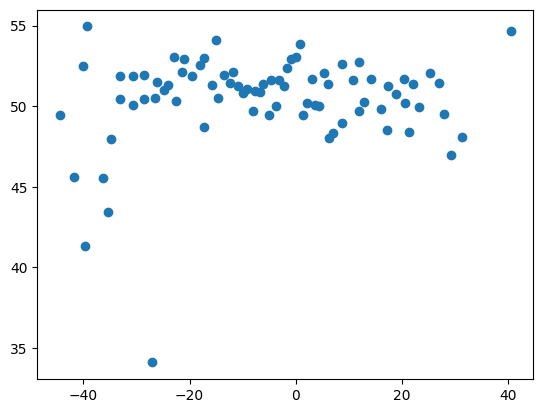

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from plotter import plot, transform_points, transform_points_inverse, transform_matrix, update_occupancy_grid, update_free_space_grid
from particle_filter import icp

# Constants
FOV_DEGREES = 101
NUM_READINGS = 101
START_DEGREE = 40
END_DEGREE = 140
CELL_SIZE = 2

# Initialize an empty occupancy grid map
map_width = 100
map_height = 100
occupancy_grid = np.zeros((map_height, map_width))


#* Calculate (x, y) coordinates of the LiDAR points ---------------
coordinates = list(plot(data, START_DEGREE, END_DEGREE, NUM_READINGS)) # -----> [(x1, y1), (x2, y2), ... ]

x_coords = [x for x, y in coordinates]
y_coords = [y for x, y in coordinates]

#plot front
plt.figure()
plt.scatter(x_coords, y_coords)
plt.show()

min and max value in occ_grid:  0.09999999999999998 0.2709999999999999
threshold calculated:  0.13419999999999996


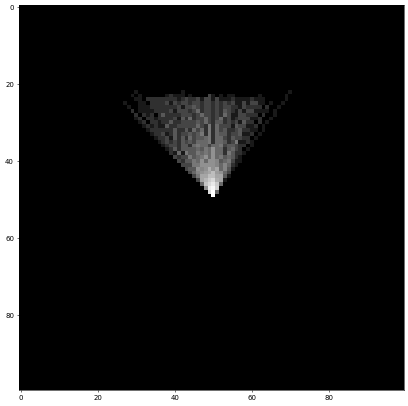

In [3]:
occupancy_grids = [np.zeros((map_height, map_width))]
free_space_grids = [np.zeros((map_height, map_width))]

#homogeneous pose
robot_pose = (0, 0, 0)  # (x, y, theta)
robot_pose = np.array([
    [np.cos(robot_pose[2]), -np.sin(robot_pose[2]), robot_pose[0]],
    [np.sin(robot_pose[2]),  np.cos(robot_pose[2]), robot_pose[1]],
    [0,              0,             1]
])

occupancy_grid, _ = update_occupancy_grid(coordinates, map_height, map_width, CELL_SIZE, occupancy_grids, alpha=0.9)
occupancy_grids = [occupancy_grid]

free_space_grid, robot_cell, robot_rotation = update_free_space_grid(robot_pose, coordinates, map_height, map_width, CELL_SIZE, free_space_grids, alpha=0.9)

#Rotate free space grid 90 degrees for display
free_space_grid_rotated = np.rot90(free_space_grid, k=1)

# Plot the occupancy grid map
plt.figure(figsize=(10, 10), dpi=50)  
plt.imshow(free_space_grid_rotated, cmap='gray', origin='upper')
plt.show()

## MCL

In [7]:

#! Monte Carlo Localization --------------------------------------------------
import numpy as np

init_pose = None
robot_pose = (0, 0, 0)  # (x, y, theta)
robot_pose = np.array([
    [np.cos(robot_pose[2]), -np.sin(robot_pose[2]), robot_pose[0]],
    [np.sin(robot_pose[2]),  np.cos(robot_pose[2]), robot_pose[1]],
    [0,              0,             1]
])

def initialize_particles(num_particles, map_width, mao_height):
    """
    Initialize particles randomly across the map.
    num_particles: Number of particles.
    grid_size: Size of the occupancy grid.
    """
    particles = np.zeros((num_particles, 3))  # x, y, theta
    particles[:, 0] = np.random.uniform(0, map_width, num_particles)
    particles[:, 1] = np.random.uniform(0, mao_height, num_particles)
    particles[:, 2] = np.random.uniform(0, 2 * np.pi, num_particles)
    return particles

def motion_update(particles, delta_pose):
    """
    Update particles based on robot motion.
    particles: Array of particles (x, y, theta).
    delta_pose: Change in pose (dx, dy, dtheta).
    """
    particles[:, 0] += delta_pose[0] + np.random.normal(0, 0.1, particles.shape[0])
    particles[:, 1] += delta_pose[1] + np.random.normal(0, 0.1, particles.shape[0])
    particles[:, 2] += delta_pose[2] + np.random.normal(0, 0.05, particles.shape[0])

def calculate_likelihood(particle, free_space_grid, occupancy_grid, robot_pose, map_width, map_height, CELL_SIZE):
    """
    Calculate the likelihood of the sensor data given the particle's state.
    particle: The state of the particle (x, y, theta).
    sensor_data: The observed sensor data.
    occupancy_grid: The occupancy grid map.
    """
    x, y, theta = particle 
    position_score = free_space_grid[int(y), int(x)]

    return position_score

def sensor_update(particles, free_space_grid, occupancy_grid, robot_pose, map_width, map_height, CELL_SIZE):
    """
    Update the weights of the particles based on sensor data.
    particles: Array of particles (x, y, theta).
    weights: Array of particle weights.
    sensor_data: The observed sensor data.
    occupancy_grid: The occupancy grid map.
    """
    weights = np.ones(len(particles))
    
    for i in range(len(particles)):
        likelihood = calculate_likelihood(particles[i], free_space_grid, occupancy_grid, robot_pose, map_width, map_height, CELL_SIZE)
        weights[i] *= likelihood

    weights /= np.sum(weights)
    return weights

def resample_particles(particles, weights):
    """
    Resample particles based on their weights.
    particles: Array of particles (x, y, theta).
    weights: Array of particle weights.
    """
    indices = np.random.choice(range(len(particles)), size=len(particles), p=weights)
    return particles[indices]

def estimate_robot_location(particles, weights):
    """
    Estimate the robot's current location using the weighted mean of particles.
    particles: Array of particles (x, y, theta).
    weights: Array of particle weights.
    """
    # Calculate the weighted mean
    mean_x = np.sum(particles[:, 0] * weights)
    mean_y = np.sum(particles[:, 1] * weights)
    mean_theta = np.sum(particles[:, 2] * weights)
    
    return mean_x, mean_y, mean_theta

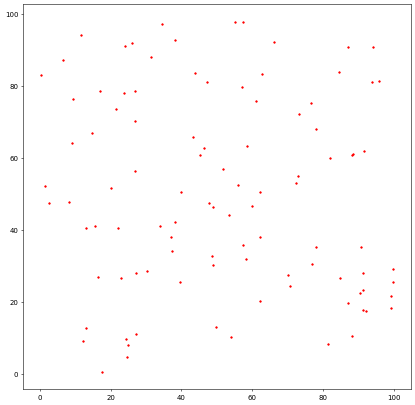

In [14]:

#! Randomly initialize particles and plot ------------------------------------
# Initialize particles
num_particles = 100  # Example number
particles = initialize_particles(num_particles, map_width, map_height)

#Plot particles
plt.figure(figsize=(10, 10), dpi=50)
plt.scatter(particles[:, 0], particles[:, 1], c='r', s=5)
plt.show()

(62.80394831170948, 51.18264690770455, 1.1306594815946067)


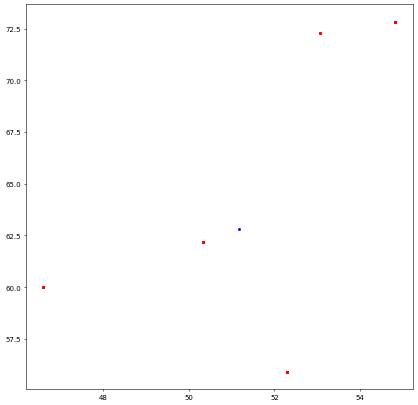

In [15]:

#! Updating with sensor data -------------------------------------------------
weights = sensor_update(particles, free_space_grid, occupancy_grid, robot_pose, map_width, map_height, CELL_SIZE)

position = estimate_robot_location(particles, weights)
print(position)

#! Resampling particles ------------------------------------------------------
particles = resample_particles(particles, weights)

#Plot particles
plt.figure(figsize=(10, 10), dpi=50)
plt.scatter(particles[:, 1], particles[:, 0], c='r', s=5)
#plot position
plt.scatter(position[1], position[0], c='b', s=10)
plt.show()

# Particle Filter

In [11]:
from plotter import plot
import numpy as np

data1 = {'f': [0, 0, 0, 0, 0, 0, 0, 0, 16, 15, 15, 15, 15, 15, 16, 16, 15, 14, 14, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 14, 
14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 15, 16, 15, 16, 16, 17, 17, 18, 18, 18, 18, 18, 17, 18, 18, 18, 18, 18, 18, 17], 'b': [29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 23, 23, 23, 22, 23, 23, 23, 23, 23, 24, 29, 24, 23, 23, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 24, 29, 29, 29, 23, 23, 23, 23, 23, 24, 25, 29, 26, 29, 29, 29, 0, 0, 64, 65, 65, 64, 64, 
63, 62, 0, 0, 0, 0, 65, 90, 77, 76, 76, 76, 75, 88, 65, 89, 89, 89, 71, 70, 70, 70, 71, 68, 71, 70, 69, 64, 68, 69, 69, 67, 69, 67, 66, 67]}

data2 = {'f': [0, 0, 0, 0, 25, 23, 16, 16, 16, 15, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 
14, 14, 14, 14, 14, 14, 13, 14, 13, 14, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 15, 15, 16, 15, 16, 
16, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 18, 17], 'b': [49, 38, 49, 38, 29, 29, 29, 24, 24, 24, 29, 29, 29, 29, 24, 24, 23, 23, 23, 23, 23, 23, 23, 30, 29, 29, 24, 23, 23, 23, 23, 23, 22, 22, 22, 22, 22, 23, 23, 23, 24, 25, 29, 29, 23, 23, 23, 23, 23, 24, 24, 24, 25, 29, 29, 24, 24, 24, 24, 29, 29, 29, 25, 29, 29, 29, 29, 29, 29, 29, 91, 89, 89, 89, 89, 89, 88, 89, 78, 80, 78, 89, 80, 72, 72, 72, 77, 77, 77, 76, 77, 70, 71, 71, 70, 70, 70, 70, 70, 77, 76]}

data1 = plot(data1, 40, 140, 220, 320, 101)
data2 = plot(data2, 40, 140, 220, 320, 101)

#to numpy array
data1 = np.array(list(data1))
data2 = np.array(list(data2))

KeyboardInterrupt: 

In [ ]:
from particle_filter_manual import icp

#T = icp(data1, data2, 1000, 0)
T = [[ 0.99797225, -0.06365053,  5.05972548],
 [ 0.06365053,  0.99797225, -1.36986665],
 [ 0.       ,   0.      ,    1.        ]]

#sample transformation of robot pose (at origin)
x = 0
y = 0
theta = 0

robot_pose = np.array([
    [np.cos(theta), -np.sin(theta), x],
    [np.sin(theta),  np.cos(theta), y],
    [0,              0,             1]
])

#apply transformation
new_robot_pose = np.dot(T, robot_pose)

print(new_robot_pose)

#turn into angle (x, y, theta)
x = new_robot_pose[0, 2]
y = new_robot_pose[1, 2]
theta = np.arctan2(new_robot_pose[1, 0], new_robot_pose[0, 0])

print(x, y, theta)

[[ 0.99797225 -0.06365053  5.05972548]
 [ 0.06365053  0.99797225 -1.36986665]
 [ 0.          0.          1.        ]]
5.05972548 -1.36986665 0.06369358734298614


In [ ]:
#Simple test
pose = np.array([0, 0, 1])
pose.dot(T.T)

AttributeError: 'list' object has no attribute 'T'

In [ ]:
x = [13,4,20,25,55,68]
y = [15,6,22,27,57,70] 

fix_error = 2
front_offset = 2.54
back_offset = 2.54

In [ ]:
import cv2
import numpy
import random
import matplotlib.pyplot
from particle_filter import icp as quick_icp
import numpy as np

n1 = 100
n2 = 75
bruit = 1/10
center = [random.random()*(2-1)*3,random.random()*(2-1)*3]
radius = random.random()
deformation = 2

template = numpy.array([
    [numpy.cos(i*2*numpy.pi/n1)*radius*deformation for i in range(n1)], 
    [numpy.sin(i*2*numpy.pi/n1)*radius for i in range(n1)]
])

data = numpy.array([
    [numpy.cos(i*2*numpy.pi/n2)*radius*(1+random.random()*bruit)+center[0] for i in range(n2)], 
    [numpy.sin(i*2*numpy.pi/n2)*radius*deformation*(1+random.random()*bruit)+center[1] for i in range(n2)]
])

a = list(zip(list(template[0]), list(template[1])))
a = np.array(a)

# Convert to homogeneous coordinates
a_homogeneous = np.hstack((a, np.ones((a.shape[0], 1))))

#sample T
T = [[ 0.99797225, -0.06365053,  5.05972548],
 [ 0.06365053,  0.99797225, -1.36986665],
 [ 0.       ,   0.      ,    1.        ]]

# Apply transformation
b = np.dot(T, a_homogeneous.T).T
b

# A* Algorith

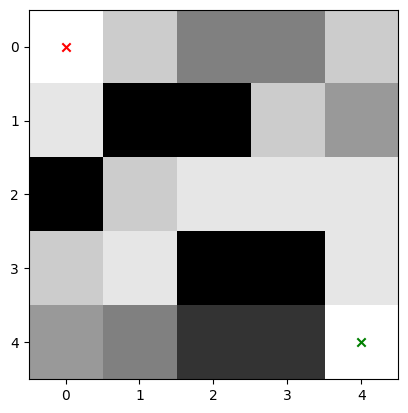

In [1]:
import numpy as np
import heapq
import random
import matplotlib.pyplot as plt

#example free space grids (1 is free, 0 is occupied)
free_space_grid = np.array([
    [1, 0.8, 0.5, 0.5, 0.8],
    [0.9, 0, 0, 0.8, 0.6],
    [0, 0.8, 0.9, 0.9, 0.9],
    [0.8, 0.9, 0, 0, 0.9],
    [0.6, 0.5, 0.2, 0.2, 1]
])

# Assuming robot_cell is defined
robot_cell = (0, 0)
end_cell = (4, 4)

# Generate a random end cell
map_height, map_width = free_space_grid.shape

#! Display the map --------------------------------------------------
plt.figure()
plt.imshow(free_space_grid, cmap='gray', origin='upper')

# Plot the path
plt.scatter(robot_cell[1], robot_cell[0], color='r', marker='x')
plt.scatter(end_cell[1], end_cell[0], color='g', marker='x')
plt.show()

In [3]:

#! A* functions ----------------------------------------------------

# if a cell is given, return the 4-connected neighbors
# probability  high -----> cost low -----> high priority
def get_neighbors(cell):

    neighbors = []
    x, y = cell

    # Check if the neighbor is within the map and is free
    if x > 0 and free_space_grid[x - 1,y] != 0:
        neighbors.append((x - 1, y))
    if x < map_width - 1 and free_space_grid[x + 1,y] != 0:
        neighbors.append((x + 1, y))
    if y > 0 and free_space_grid[x, y - 1] != 0:
        neighbors.append((x, y - 1))
    if y < map_height - 1 and free_space_grid[x, y + 1] != 0:
        neighbors.append((x, y + 1))

    return neighbors

def cost(current_cell, neighbor):

    if(current_cell.parent):
        parent = current_cell.parent.value
    else:
        parent = current_cell.value

    current = current_cell.value

    #check if direction has not changed
    direction1 = (parent[0] - current[0], parent[1] - current[1])
    direction2 = (current[0] - neighbor[0], current[1] - neighbor[1])

    if direction1 == direction2:
        penalty = 0.1
    else:
        penalty = 0.5

    return penalty + round(1 - free_space_grid[neighbor],2)

def heuristic(current_cell, end_cell):
    return abs(current_cell[0] - end_cell[0]) + abs(current_cell[1] - end_cell[1])


In [4]:
class node:

    childs = []
    parent = None
    cost = 0
    name = ""
    value = None

    #Constructor
    def __init__(self, value=None, childs=[], parent=None, cost=0, name=None):

        self.childs = childs
        self.value = value
        self.name = name
        self.parent = parent
        self.cost = cost

    #print function / string representation
    def __repr__(self) -> str:

        if(self.name):
            return self.name
        else:
            return str(self.value)
        
    #equality function
    def __eq__(self, o: object) -> bool:
        return self.value == o.value

def astar(start_cell, end_cell):

    unvisited = []
    visited = []

    # Create the start node
    start_node = node(start_cell, cost=0)

    # Add the start node to the unvisited list
    unvisited.append(start_node)

    while unvisited:

        # Get the node with the minimum cost
        current_node = min(unvisited, key=lambda x: x.cost)

        # Remove the current node from the unvisited list
        unvisited.remove(current_node)

        # Add the current node to the visited list
        visited.append(current_node)

        # Check if the current node is the end node
        if current_node.value == end_cell:
            path = []
            while current_node:
                path.append(current_node.value)
                current_node = current_node.parent
            return path[::-1]

        # Get the neighbors of the current node
        neighbors = get_neighbors(current_node.value)

        for neighbor in neighbors:

            # Create the neighbor node
            neighbor_node = node(neighbor, parent=current_node, cost=current_node.cost + cost(current_node, neighbor) + heuristic(neighbor, end_cell))

            # Check if the neighbor is in the visited list
            if neighbor_node in visited:
                continue

            # Check if the neighbor is in the unvisited list
            if neighbor_node not in unvisited:
                unvisited.append(neighbor_node)
            else:
                # Replace the neighbor node with the new node if the new node has a lower cost
                for node_ in unvisited:
                    if node_ == neighbor_node and node_.cost > neighbor_node.cost:
                        node_ = neighbor_node
    return None

def simplify_path(path):
    if not path:
        return []

    simplified_path = []
    current_direction = None

    for i in range(1, len(path)):
        prev_cell = path[i - 1]
        current_cell = path[i]

        # Calculate the direction of movement
        direction = (current_cell[0] - prev_cell[0], current_cell[1] - prev_cell[1])

        if direction != current_direction:
            simplified_path.append(prev_cell)
            current_direction = direction

    simplified_path.append(path[-1])
    
    return simplified_path

# Run the A* algorithm
path = astar(robot_cell, end_cell)
print("Path:", path)
simplified_path = simplify_path(path)
print("Simplified Path:", simplified_path)

Path: [(0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (2, 3), (2, 4), (3, 4), (4, 4)]
Simplified Path: [(0, 0), (0, 3), (2, 3), (2, 4), (4, 4)]


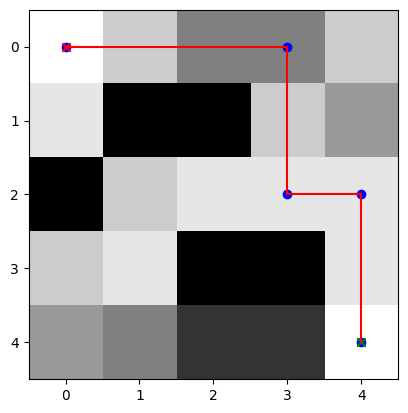

In [5]:

#! Display the map --------------------------------------------------
plt.figure()
plt.imshow(free_space_grid, cmap='gray', origin='upper')

# Plot the path as a line
path = np.array(path)
simplified_path = np.array(simplified_path)
#plot simplified dots
plt.scatter(simplified_path[:, 1], simplified_path[:, 0], color='b')
plt.plot(path[:, 1], path[:, 0], 'r')
plt.scatter(robot_cell[1], robot_cell[0], color='r', marker='x')
plt.scatter(end_cell[1], end_cell[0], color='g', marker='x')
plt.show()

# Orientation Calculation

In [58]:
before = [[ 0.99999587 ,0.00287304, -0.09668887],
 [-0.00287304,  0.99999587, -0.09882394],
 [ 0.0,          0.0,          1.0        ]]

after = [[ 0.97913645, -0.20320386,  7.46539383],
 [ 0.20320386,  0.97913645,  1.92814546],
 [ 0.0,          0.0,          1.0        ]]

rotation = np.arctan2(after[1][0], after[0][0])

#to degrees
rotation = np.rad2deg(rotation + np.pi/2)
print(rotation)

101.72437491098134


In [59]:
a = (0,0)
b = (-5,5)

line_vector = (b[0] - a[0], b[1] - a[1])

# tan inverse
target_angle = np.arctan2(line_vector[1], line_vector[0])

#to degrees
target_angle = np.rad2deg(target_angle)
print(target_angle)

135.0


# Breaking Clumps

In [18]:
from scipy.ndimage import median_filter

def median_filter_occupancy_grid(occupancy_grid, size=2):
    """
    Apply a median filter to the occupancy grid.
    
    Args:
    - occupancy_grid (np.ndarray): The occupancy grid to be filtered.
    - size (int): The size of the filter.

    Returns:
    - filtered_grid (np.ndarray): The filtered occupancy grid.
    """
    filtered_grid = median_filter(occupancy_grid, size=size)
    return filtered_grid

In [19]:
from scipy.ndimage import binary_erosion, binary_dilation

def morphological_operations_occupancy_grid(occupancy_grid, structure=None):
    """
    Apply morphological operations to the occupancy grid.
    
    Args:
    - occupancy_grid (np.ndarray): The occupancy grid to be processed.
    - structure (np.ndarray): The structuring element used for the operations.

    Returns:
    - processed_grid (np.ndarray): The processed occupancy grid.
    """
    if structure is None:
        structure = np.ones((3, 3))
    
    # Erosion followed by dilation (opening)
    eroded_grid = binary_erosion(occupancy_grid, structure=structure)
    processed_grid = binary_dilation(eroded_grid, structure=structure)
    
    return processed_grid

In [20]:
from scipy.ndimage import label

def connected_component_analysis(occupancy_grid):
    """
    Apply connected component analysis to the occupancy grid.
    
    Args:
    - occupancy_grid (np.ndarray): The occupancy grid to be analyzed.

    Returns:
    - labeled_grid (np.ndarray): The labeled occupancy grid with connected components.
    """
    labeled_grid, num_features = label(occupancy_grid)
    return labeled_grid, num_features

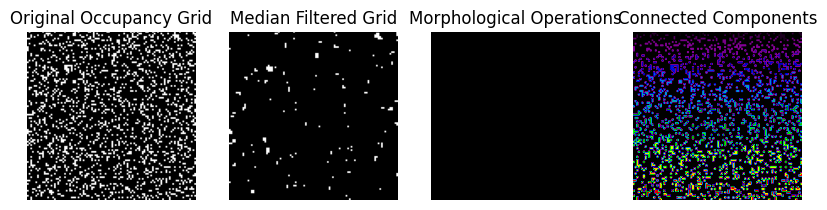

In [21]:
import numpy as np
import random

# Create a 2D occupancy grid
occupancy_grid = np.zeros((100, 100))

#Randomly assign occupied cells
for i in range(100):
    for j in range(100):
        if random.random() < 0.2:
            occupancy_grid[i, j] = 1

# Apply median filter
filtered_grid_median = median_filter_occupancy_grid(occupancy_grid, size=3)

# Apply morphological operations
processed_grid_morph = morphological_operations_occupancy_grid(occupancy_grid)

# Apply connected component analysis
labeled_grid, num_features = connected_component_analysis(occupancy_grid)

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(occupancy_grid, cmap='gray')
plt.title('Original Occupancy Grid')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(filtered_grid_median, cmap='gray')
plt.title('Median Filtered Grid')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(processed_grid_morph, cmap='gray')
plt.title('Morphological Operations')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(labeled_grid, cmap='nipy_spectral')
plt.title('Connected Components')
plt.axis('off')

plt.show()

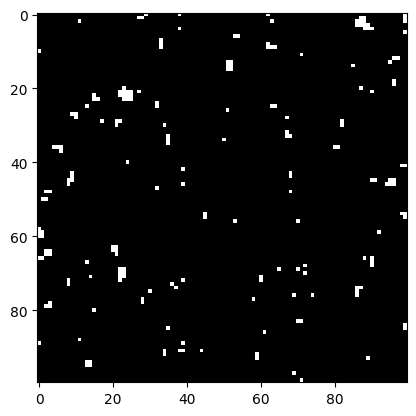

In [22]:
from skimage.filters import threshold_local

def adaptive_threshold_occupancy_grid(occupancy_grid, block_size=35, offset=10):
    """
    Apply adaptive thresholding to the occupancy grid.
    
    Args:
    - occupancy_grid (np.ndarray): The occupancy grid to be thresholded.
    - block_size (int): The size of the neighborhood used for thresholding.
    - offset (float): The constant subtracted from the mean or median.

    Returns:
    - thresholded_grid (np.ndarray): The thresholded occupancy grid.
    """
    adaptive_thresh = threshold_local(occupancy_grid, block_size, offset=offset)
    thresholded_grid = occupancy_grid > adaptive_thresh
    return thresholded_grid.astype(np.float32)

#plot

threshold_local_output = median_filter_occupancy_grid(occupancy_grid, size=3)

plt.figure()
plt.imshow(threshold_local_output, cmap='gray')
plt.show()


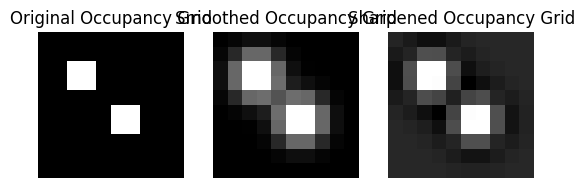

In [3]:
from scipy.ndimage import gaussian_filter
from scipy.ndimage import laplace

def smooth_occupancy_grid(occupancy_grid, sigma=0):
    """
    Apply Gaussian smoothing to the occupancy grid.
    
    Args:
    - occupancy_grid (np.ndarray): The occupancy grid to be smoothed.
    - sigma (float): The standard deviation for Gaussian kernel.

    Returns:
    - smoothed_grid (np.ndarray): The smoothed occupancy grid.
    """
    smoothed_grid = gaussian_filter(occupancy_grid, sigma=sigma)
    return smoothed_grid

def sharpen_occupancy_grid_laplacian(occupancy_grid, alpha=1.0):
    """
    Apply sharpening to the occupancy grid using the Laplacian method.
    
    Args:
    - occupancy_grid (np.ndarray): The occupancy grid to be sharpened.
    - alpha (float): The strength of the sharpening effect.

    Returns:
    - sharpened_grid (np.ndarray): The sharpened occupancy grid.
    """
    laplacian_grid = laplace(occupancy_grid)
    sharpened_grid = occupancy_grid - alpha * laplacian_grid
    return sharpened_grid

#plot example
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D occupancy grid
occupancy_grid = np.zeros((10, 10))

#some clumps of occupied cells
occupancy_grid[2:4, 2:4] = 1
occupancy_grid[5:7, 5:7] = 1

# Smooth the occupancy grid
sigma = 0.9
smoothed_grid = gaussian_filter(occupancy_grid, sigma=sigma)

# Sharpen the blurry occupancy grid using Laplacian method
alpha = 1.0
sharpened_grid = sharpen_occupancy_grid_laplacian(smoothed_grid, alpha=alpha)

# Plot the occupancy grid
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(occupancy_grid, cmap='gray')
plt.title('Original Occupancy Grid')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(smoothed_grid, cmap='gray')
plt.title('Smoothed Occupancy Grid')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sharpened_grid, cmap='gray')
plt.title('Sharpened Occupancy Grid')
plt.axis('off')

plt.show()

# Anti Clumping

In [21]:

#! Erotion and Dilation --------------------------------------------------

import cv2
import numpy as np

# Create a sample occupancy grid (binary image)
occupancy_grid = np.array([[0, 0.1, 0.5, 0.1, 0],
                           [0, 0.5, 1, 1, 0],
                           [0, 1, 1, 1, 0],
                           [0, 1, 1, 1, 0],
                           [0, 1, 1, 1, 0]],)

# Define the kernel for morphological operations
kernel = np.ones((3, 3), np.uint8)

# Apply erosion
eroded_grid = cv2.erode(occupancy_grid, kernel, iterations=1)

# Apply dilation
dilated_grid = cv2.dilate(eroded_grid, kernel, iterations=1)

print("Original Grid:\n", occupancy_grid)
print("Eroded Grid:\n", eroded_grid)
print("Dilated Grid:\n", dilated_grid)


Original Grid:
 [[0.  0.1 0.5 0.1 0. ]
 [0.  0.5 1.  1.  0. ]
 [0.  1.  1.  1.  0. ]
 [0.  1.  1.  1.  0. ]
 [0.  1.  1.  1.  0. ]]
Eroded Grid:
 [[0.  0.  0.1 0.  0. ]
 [0.  0.  0.1 0.  0. ]
 [0.  0.  0.5 0.  0. ]
 [0.  0.  1.  0.  0. ]
 [0.  0.  1.  0.  0. ]]
Dilated Grid:
 [[0.  0.1 0.1 0.1 0. ]
 [0.  0.5 0.5 0.5 0. ]
 [0.  1.  1.  1.  0. ]
 [0.  1.  1.  1.  0. ]
 [0.  1.  1.  1.  0. ]]


In [11]:

#! GMM -------------------------------------------------------------------

import numpy as np
from sklearn.mixture import GaussianMixture

# Create a sample occupancy grid (binary image)
occupancy_grid = np.array([[0, 1, 1, 1, 0],
                           [0, 1, 1, 1, 0],
                           [0, 1, 1, 1, 0],
                           [0, 1, 1, 1, 0],
                           [0, 1, 1, 1, 0]], dtype=np.uint8)

# Extract coordinates of occupied cells
occupied_coords = np.column_stack(np.where(occupancy_grid == 1))

# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=1)  # Assuming we want to merge into one line
gmm.fit(occupied_coords)

# Predict the cluster for each point (though we have only one cluster here)
labels = gmm.predict(occupied_coords)

# Calculate the mean of the cluster to represent the merged line
cluster_center = gmm.means_[0]

# Create an empty occupancy grid
updated_grid = np.zeros_like(occupancy_grid)

# Update the grid with the cluster center
x, y = int(cluster_center[0]), int(cluster_center[1])
updated_grid[x, y] = 1

print("Original Occupancy Grid:\n", occupancy_grid)
print("Updated Occupancy Grid:\n", updated_grid)

Original Occupancy Grid:
 [[0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]]
Updated Occupancy Grid:
 [[0 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
